# U-Net CNN Model

## Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from keras import backend as K

In [ ]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def build_model(shape):
    num_filters = [64, 128, 256, 512]
    inputs = Input(shape)

    skip_x = []
    x = inputs

    # ENCODER
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPooling2D((2, 2))(x)

    # BRIDGE
    x = conv_block(x, 1024)

    num_filters.reverse()
    skip_x.reverse()

    # DECODER
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]

        # Apply cropping or padding to match shapes
        diff_h = xs.shape[1] - x.shape[1]
        diff_w = xs.shape[2] - x.shape[2]

        if diff_h > 0:
            x = ZeroPadding2D(((0, diff_h), (0, 0)))(x)
        elif diff_h < 0:
            xs = ZeroPadding2D(((0, -diff_h), (0, 0)))(xs)

        if diff_w > 0:
            x = ZeroPadding2D(((0, 0), (0, diff_w)))(x)
        elif diff_w < 0:
            xs = ZeroPadding2D(((0, 0), (0, -diff_w)))(xs)

        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    # OUTPUT
    x = Conv2D(1, (1, 1), padding="same")(x)  # Output with 1 channel
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [ ]:
input_shape = (300, 130, 3)
model = build_model(input_shape)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 130, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 300, 130, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 300, 130, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 300, 130, 64)         0         ['batch_normalization[0][0

## Getting Train-Valid-Test Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

# TRAIN
trainimageNP = np.load("/content/drive/My Drive/MANDIBLE/train_img.npy")
trainmaskNP = np.load("/content/drive/My Drive/MANDIBLE/train_mask.npy")

# VALID
validimageNP = np.load("/content/drive/My Drive/MANDIBLE/valid_img.npy")
validmaskNP = np.load("/content/drive/My Drive/MANDIBLE/valid_mask.npy")

# TEST
testimageNP = np.load("/content/drive/My Drive/MANDIBLE/test_img.npy")
testmaskNP = np.load("/content/drive/My Drive/MANDIBLE/test_mask.npy")

In [ ]:
print(trainimageNP.shape)
print(trainmaskNP.shape)
print(validimageNP.shape)
print(validmaskNP.shape)
print(testimageNP.shape)
print(testmaskNP.shape)

(1626, 300, 130, 3)
(1626, 300, 130)
(465, 300, 130, 3)
(465, 300, 130)
(233, 300, 130, 3)
(233, 300, 130)


## Epoch Training

In [ ]:
lr = 1e-4
batchSize = 32
epochs = 25

In [ ]:
drive_path = '/content/drive/My Drive/MANDIBLE/models/unet.keras'

In [ ]:
import time
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Compile the model
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Calculate steps per epoch and validation steps
stepsPerEpoch = len(trainimageNP) // batchSize
validationSteps = len(validimageNP) // batchSize

# Define callbacks
callbacks = [
    ModelCheckpoint(drive_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="min")
]

# Record the start time
start_time = time.time()

# Train the model
history = model.fit(trainimageNP, trainmaskNP,
                    batch_size=batchSize,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(validimageNP, validmaskNP),
                    validation_steps=validationSteps,
                    steps_per_epoch=stepsPerEpoch,
                    shuffle=True,
                    callbacks=callbacks
                    )

# Record the end time
end_time = time.time()

# Calculate the training duration
training_time = end_time - start_time

print(f"Training time: {training_time:.2f} seconds")

Epoch 1/25
50/50 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9031
Epoch 1: val_loss improved from inf to 0.98896, saving model to /content/drive/My Drive/MANDIBLE/models/unet.keras
50/50 [==============================] - 136s 1s/step - loss: 0.2311 - accuracy: 0.9031 - val_loss: 0.9890 - val_accuracy: 0.4535 - lr: 1.0000e-04
Epoch 2/25
50/50 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9586
Epoch 2: val_loss improved from 0.98896 to 0.59848, saving model to /content/drive/My Drive/MANDIBLE/models/unet.keras
50/50 [==============================] - 107s 1s/step - loss: 0.1097 - accuracy: 0.9586 - val_loss: 0.5985 - val_accuracy: 0.6918 - lr: 1.0000e-04
Epoch 3/25
50/50 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9702
Epoch 3: val_loss improved from 0.59848 to 0.56331, saving model to /content/drive/My Drive/MANDIBLE/models/unet.keras
50/50 [==============================] - 65s 1s/step - loss: 0.0817 - a

## Performance Visualization

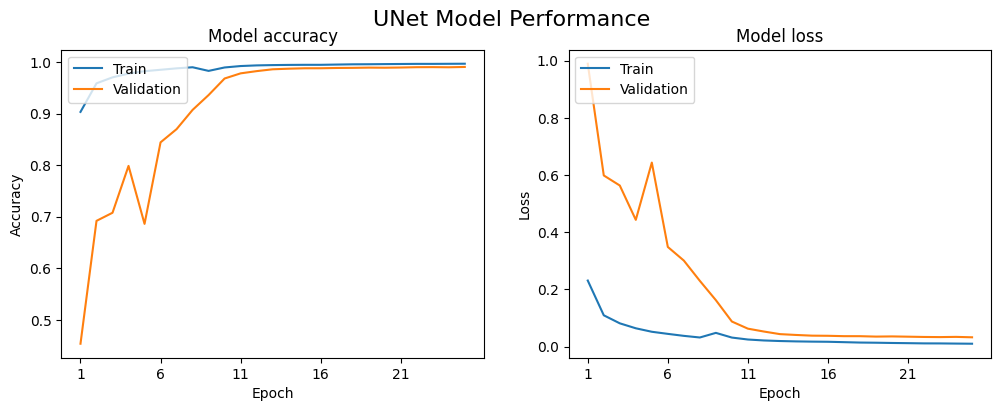

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Determine the number of epochs
epochs = len(history.history['accuracy'])
interval = 5

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), history.history['accuracy'])
plt.plot(range(1, epochs + 1), history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(1, epochs + 1, interval))  # Set x-ticks with interval

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), history.history['loss'])
plt.plot(range(1, epochs + 1), history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(range(1, epochs + 1, interval))  # Set x-ticks with interval

# Add an overall title
plt.suptitle('UNet Model Performance', fontsize=16)

plt.show()

## Evaluating on Test Set

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model(drive_path)

test_loss, test_accuracy = best_model.evaluate(testimageNP, testmaskNP, verbose=1)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

8/8 [==============================] - 10s 1s/step - loss: 0.0390 - accuracy: 0.9889
Test Loss: 0.03895827755331993
Test Accuracy: 0.988854169845581
